## Air Pollution Data
These data record the level of atmospheric ozone concentration from eight daily meteorological measurements made in the Los Angeles basin in 1976. Although measurements were made every day that year, some observations were missing; here we have the 330 complete cases. The data were given to us by Leo Breiman; he was a consultant on a project from which these data are taken. The response, referred to as ozone, is actually the log of the daily maximum of the hourly-average ozone
concentrations in Upland, California.

Variables:

|        |                                                       |
|--------|-------------------------------------------------------|
|ozone   |Upland Maximum Ozone                                   |
|vh      |Vandenberg 500 mb Height                               |
|wind    |Wind Speed (mph)                                       |
|humidity|Humidity (%)                                           |
|temp    |Sandburg AFB Temperature                               |
|ibh     |Inversion Base Height                                  |
|dpg     |Daggot Pressure Gradient                               |
|ibt     |Inversion Base Temperature                             |
|vis     |Visibility (miles)                                     |
|doy     |Day of the Year                                        |

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

# set common plots properties
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
# define commonly used colors
RED, BLUE, GRAY4 = '#FF5865', '#0000FF', '#646369'

## Load and Prepare Data

In [2]:
df = pd.read_csv("../data/LAozone.data.txt", sep=',')
df.head()

,ozone,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
0,3,5710,4,28,40,2693,-25,87,250,3
1,5,5700,3,37,45,590,-24,128,100,4
2,5,5760,3,51,54,1450,25,139,60,5
3,6,5720,4,69,35,1568,15,121,60,6
4,4,5790,6,19,45,2631,-33,123,100,7


## Smoothing Splines
Unfortunately, I did not find any Python library for smoothing splines of a similar implementation from the book. Let's implement it ourselves. The detailed explanation, formulas and deriviation is here https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/examples/Bone%20Mineral%20Density.ipynb

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List
from numpy.linalg import inv
from scipy import optimize

In [4]:
class SmoothingSpline1D(BaseEstimator, TransformerMixin):
    """One dimensional smoothing spline.
    Parameters
    ----------
    dof :
        The target effective degrees of of freedom of a smoothing spline.
    Attributes
    ----------
    knots_:
        Unique values of X training data.
    smooth_:
        The smoothing parameter that results in the target degrees of freedom.
    coef_:
        The vector of fitted coefficients for linear regression."""
    def __init__(self, dof: float):
        self.dof = dof

    def fit(self, X: np.ndarray, y: np.array) -> 'SmoothingSpline1D':
        """Fit SmoothingSpline1D model according to the given training data
           and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        y = np.atleast_2d(y).T
        self.knots_ = np.unique(X)
        N = self.__expand_natural_cubic(X, self.knots_)
        O = self.__calc_integral_matrix(self.knots_)
        self.smooth_ = optimize.newton(
            lambda s: self.__calc_dof(N, O, s) - self.dof,
            0.5, maxiter=400)
        self.coef_ = inv(N.T @ N + self.smooth_ * O) @ N.T @ y
        self.Sl_ = self.__calc_Sl(N, O, self.smooth_)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Natural cubic spline basis expansion.
        Parameters
        ----------
        X :
            Input data.
        Returns
        -------
        X_new :
            Transformed data.
        """
        return self.__expand_natural_cubic(X, self.knots_)

    def predict(self, X: np.ndarray) -> np.array:
        return self.transform(X) @ self.coef_

    @staticmethod
    def __calc_Sl(N, O, smoothing):
        return N @ inv(N.T @ N + smoothing * O) @ N.T

    @staticmethod
    def __calc_dof(N, O, smoothing):
        if smoothing < 0:
            smoothing = 0
        return np.trace(SmoothingSpline1D.__calc_Sl(N, O, smoothing))

    @staticmethod
    def __dk(X: np.ndarray, knot: float, knot_last: float) -> np.ndarray:
        return (X - knot).clip(0) ** 3 / (knot_last - knot)

    @staticmethod
    def __expand_natural_cubic(X: np.ndarray, knots: np.array) -> np.ndarray:
        basis_splines = [np.ones(shape=(X.size, 1)), X]
        dk_last = SmoothingSpline1D.__dk(X, knots[-2], knots[-1])
        for knot in knots[:-2]:
            dk = SmoothingSpline1D.__dk(X, knot, knots[-1])
            basis_splines.append(dk - dk_last)
        return np.hstack(basis_splines)

    @staticmethod
    def __calc_integral_matrix(knots: np.array) -> np.ndarray:
        O = np.zeros(shape=(knots.size, knots.size))
        for i in range(2, knots.size):
            for j in range(i, knots.size):
                O[i, j] = O[j, i] = SmoothingSpline1D.__calc_integral(
                    knots[i-2], knots[j-2], knots[-2], knots[-1])
        return O

    @staticmethod
    def __calc_integral(i, j, p, l):
        return (-18*i*j*j + 12*i*j*l + 24*i*j*p - 12*i*l*p - 6*i*p*p +
                6*j*j*j - 12*j*l*p - 6*j*p*p + 12*l*p*p) / \
               (i*j - i*l - j*l + l*l)

In [5]:
X, y = df[['dpg']].values, df.ozone.values
sp_5dof = SmoothingSpline1D(dof=5).fit(X, y)
sp_11dof = SmoothingSpline1D(dof=11).fit(X, y)

x_plot = np.linspace(sp_5dof.knots_[0], sp_5dof.knots_[-1], 100)
y_plot_5dof = sp_5dof.predict(np.atleast_2d(x_plot).T)
y_plot_11dof = sp_11dof.predict(np.atleast_2d(x_plot).T)

## FIGURE 5.7. Plotting

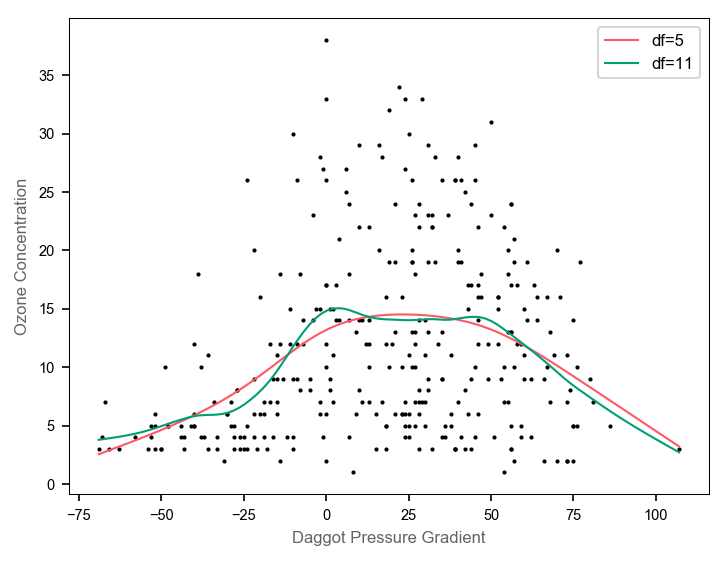

In [6]:
# FIGURE 5.7. (Top:) Smoothing spline fit of ozone concentration versus Daggot
#             pressure gradient. The two fits correspond to different values of
#             the smoothing parameter, chosen to achieve five and eleven
#             effective degrees of freedom, defined by
#             df_lambda = trase(S_lambda).
fig, ax = plt.subplots(figsize=(5.5, 4.2), dpi=150)
ax.plot(x_plot, y_plot_5dof, color=RED, linewidth=1, label='df=5')
ax.plot(x_plot, y_plot_11dof, color='#009E73', linewidth=1, label='df=11')
ax.scatter(X, y, color='black', s=1)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.set_xlabel('Daggot Pressure Gradient', color=GRAY4, fontsize=8)
ax.set_ylabel('Ozone Concentration', color=GRAY4, fontsize=8)
_ = ax.legend(loc='upper right', prop={'size': 8})

In [7]:
# calculate eigenvalues and eigenvectors of the smoothing matrix
def eig_smoothing_matrix(sp):
    w, v = np.linalg.eig(sp.Sl_)
    # the smoothing matrix is semidifinite positive and thus should have
    # positive real eigenvalues, but due to floating point precision numpy eig
    # function returns complex and small negative values, take its real part
    w, v = np.real(w).clip(0), np.real(v)
    return w[np.argsort(w)[::-1]], v[:, np.argsort(w)[::-1]]

sp_5dof_eigvals, sp_5dof_eigvecs = eig_smoothing_matrix(sp_5dof)
sp_11dof_eigvals, sp_11dof_eigvecs = eig_smoothing_matrix(sp_11dof)
x_plot = list(range(1, 26))

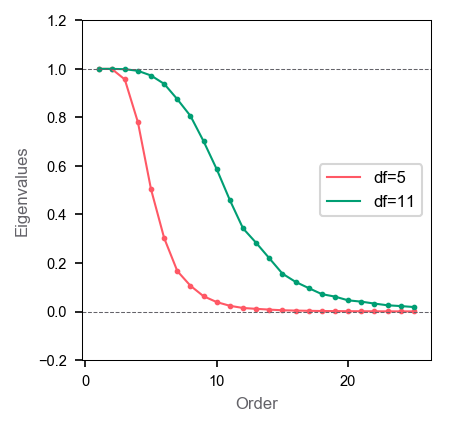

In [8]:
# FIGURE 5.7. (Lower left:) First 25 eigenvalues for the two smoothing-spline
#             matrices. The first two are exactly 1, and all are >= 0.
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.plot(x_plot, sp_5dof_eigvals[:25], color=RED, linewidth=1, label='df=5')
ax.plot(
    x_plot, sp_11dof_eigvals[:25], color='#009E73', linewidth=1, label='df=11')
ax.scatter(x_plot, sp_5dof_eigvals[:25], color=RED, s=3)
ax.scatter(x_plot, sp_11dof_eigvals[:25], color='#009E73', s=3)
ax.axhline(y=0, c=GRAY4, linewidth=0.5, linestyle='--')
ax.axhline(y=1, c=GRAY4, linewidth=0.5, linestyle='--')
ax.set_ylim(-0.2, 1.2)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.set_xlabel('Order', color=GRAY4, fontsize=8)
ax.set_ylabel('Eigenvalues', color=GRAY4, fontsize=8)
_ = ax.legend(loc='center right', prop={'size': 8})

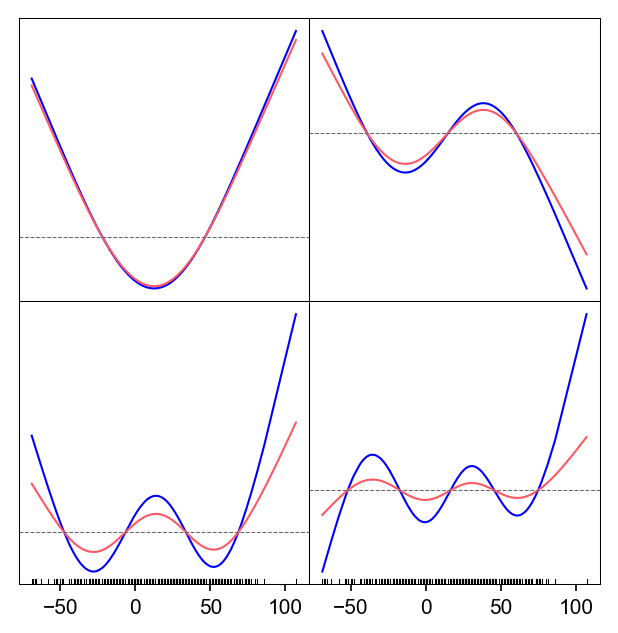

In [9]:
# FIGURE 5.7. (Lower right:) Third to sixth eigenvectors of the spline smoother
#             matrices. In each case, u_k is plotted against x, and as such is
#             viewed as a function of x. The rug at the base of the plots
#             indicate the occurrence of data points. The damped functions
#             represent the smoothed versions of theses functions (using the 5
#             df smoother).
fig, axarr = plt.subplots(2, 2, figsize=(5, 5), dpi=150)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
x_order = np.argsort(np.squeeze(X))
x_plot = np.linspace(np.min(X), np.max(X), 100)
for i in range(2):
    for j in range(2):
        evec = sp_11dof_eigvecs[x_order, 2+i*2+j]
        axarr[i, j].plot(X[x_order], evec, color=BLUE, linewidth=1)
        evec_damped = SmoothingSpline1D(dof=5).fit(X[x_order], evec).predict(
            np.atleast_2d(x_plot).T)
        axarr[i, j].plot(x_plot, evec_damped, color=RED, linewidth=1)
        axarr[i, j].axhline(y=0, c=GRAY4, linewidth=0.5, linestyle='--')
        axarr[i, j].tick_params(
            axis='x', which='both', bottom=(i == 1), labelbottom=(i == 1))
        axarr[i, j].tick_params(
            axis='y', which='both', left=False, labelleft=False)
        if i == 1:
            # plot bottom black lines representing samples
            y_from, y_to = axarr[i, j].get_ylim()
            for e in range(X.shape[0]):
                x = X[e, 0]
                axarr[i, j].plot(
                    [x, x], [y_from, y_from+(y_to-y_from)*0.02],
                    color='black', linewidth=0.5)
            axarr[i, j].set_ylim(y_from, y_to)